In [ ]:
# default_exp processing

In [ ]:
#export
from functools import partial
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
#export
def eyetrack_stim_inten(stim_inten, eye_track, 
                        upsampling=2,
                        eye_calib=[[94 ,18], [ 8, 59]],
                        box_w=None, box_h=None):
    """From stimulus data and eye tracking, returns a corrected and upsampled stimulus data."""
    eye_x, eye_y = eye_track[:,0], eye_track[:,1]
    shape_y, shape_x = stim_inten.shape[-2:]
    if box_w is None:
        box_w = 1280//shape_x
    if box_h is None:
        box_h = 720//shape_y

    if shape_y>1 and shape_x>1:
        box_w, box_h = int(box_w/upsampling), int(box_h/upsampling)
    elif shape_y > 1:
        box_w, box_h = box_w                , int(box_h/upsampling)
    elif shape_x > 1:
        box_w, box_h = int(box_w/upsampling), box_h
    
    eye_transfo_f = _eye_to_stim_f(eye_calib=eye_calib, 
                                  box_width=box_w,
                                  box_height=box_h)
    
    if shape_y>1 and shape_x>1:
        stim_inten = stim_inten.repeat(upsampling,axis=1).repeat(upsampling,axis=2)
    elif shape_y > 1:
        stim_inten = stim_inten.repeat(upsampling,axis=1)
    elif shape_x > 1:
        stim_inten = stim_inten.repeat(upsampling,axis=2)
        
    xpos_avg = np.mean(eye_x)
    ypos_avg = np.mean(eye_y)
    
    #After getting the shift of the matrix to apply, we roll the matrix instead of extending it to the shifts
    #This seems strange, but from the cell point of view, that is potentially looking at no stimulus,
    # the response it gives are uncorrelated with the stimulus, and so shouldn't impact further analysis
    # Advantage is that it keeps the data small enough, without loosing regions of the stimulus.
    for i in range(len(stim_inten)):
        stim_shift_x, stim_shift_y = eye_transfo_f(x_eyeShift=eye_x[i]-xpos_avg, 
                                                   y_eyeShift=eye_y[i]-ypos_avg)
        if shape_y>1 and shape_x>1:
            rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
            rolled_stim = np.roll(rolled_stim  ,stim_shift_x,axis=1)
        elif shape_y > 1:
            rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
        elif shape_x > 1:
            rolled_stim = np.roll(stim_inten[i],stim_shift_x,axis=1)
        stim_inten[i] = rolled_stim
        
    return stim_inten

def _eye_to_stim_f(eye_calib, box_width, box_height):
    eye_to_stim     = np.linalg.inv(eye_calib)
    box_dim         = np.array([1280/(box_width), 720/(box_height)])
    return partial(_linear_transform, box_dim=box_dim, transfo_matrix=eye_to_stim)
    
def _linear_transform(box_dim, transfo_matrix, x_eyeShift, y_eyeShift):
    transform_coord = np.dot(transfo_matrix, np.array([x_eyeShift, y_eyeShift]).T)
    stim_vec        = np.round(transform_coord * box_dim).astype(int)
    return stim_vec[0], -stim_vec[1]

In [ ]:
from theonerig.core import *
from theonerig.utils import *
from os.path import join
import matplotlib.pyplot as plt
vivo_2p_dir = "./files/vivo_2p"
reM = import_record(join(vivo_2p_dir, "record_master.h5"))

<IPython.core.display.Javascript object>


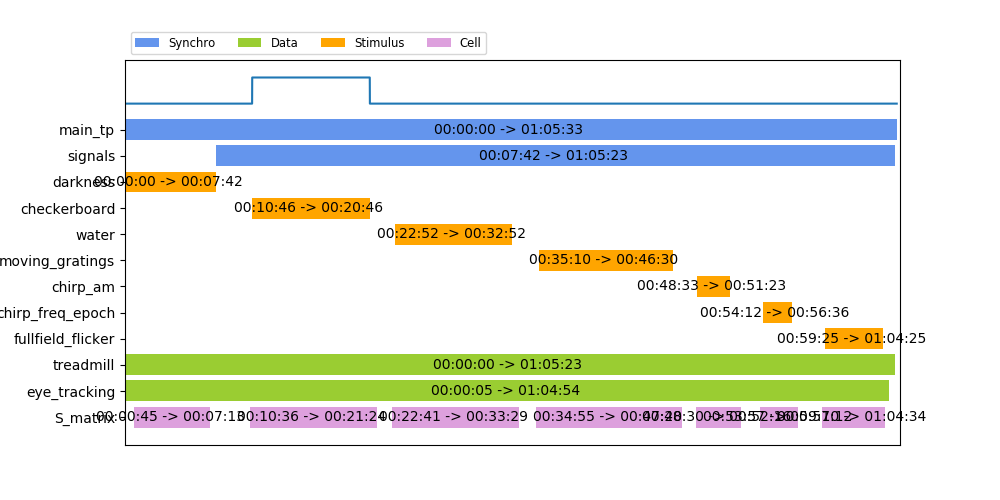

In [ ]:
pipe = Data_Pipe(reM, ["checkerboard", "eye_tracking", "S_matrix"], ["stim_inten", "eye_track", "spike_counts"])
pipe += "checkerboard"
reM.plot()
pipe.plot()

In [ ]:
stim_inten_corrected = eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"])

In [ ]:
print(pipe[0]["stim_inten"].shape)
print(stim_inten_corrected.shape)

(36000, 15, 20)
(36000, 30, 40)


In [ ]:
#export
def process_sta_batch(stim_inten, spike_counts, Hw=30, Fw=2):
    """Calculate the STA for a batch of cells."""
    #Preparing the stimulus
    shape_y, shape_x = stim_inten.shape[-2:]
    stim_inten = stim_inten_norm(stim_inten)
    
    #We just have to calculate one STA over the whole record
    stim_inten   = np.reshape(stim_inten, (len(stim_inten),-1))
    stim_inten   = np.transpose(stim_inten)
    allCells_sta = _staEst_fromBins(stim_inten, spike_counts, Hw, Fw=Fw)

    for k, cell_sta in enumerate(allCells_sta): #Easy way to do normalization for each cell that works for all possible shapes
        allCells_sta[k] = np.nan_to_num(cell_sta/np.max(np.abs(cell_sta)))
    if shape_y>1 and shape_x>1:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw, shape_y, shape_x))
    elif shape_y>1 or shape_x>1:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw,-1))
    else:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw))

    return allCells_sta

def _staEst_fromBins(stim, spike_counts, Hw, Fw=0):
    """Fw is the amount of frame after a spike that we calculate the average for.
        stim must be of shape (x*y,n_frame)
        spike_counts must be of shape (n_frame, n_cells)
        Return sta of all cells in the shape (n_cells, Hw+Fw, y*x) """
    spike_counts[:Hw] = 0
    
    spike_counts = np.nan_to_num(spike_counts / np.sum(spike_counts,axis=0))
    spike_counts = spike_counts - np.mean(spike_counts,axis=0)
    sta = np.zeros((Hw+Fw, stim.shape[0], spike_counts.shape[-1]))
    for i in range(Hw):
        sta[(Hw-1-i),:,:] = np.dot(stim, spike_counts)
        spike_counts = np.roll(spike_counts, -1, axis=0)
    spike_counts = np.roll(spike_counts, Hw, axis=0)
    if Fw != 0:
        spike_counts[-Fw:] = 0
    for i in range(Fw):
        spike_counts  = np.roll(spike_counts, 1, axis=0)
        sta[Hw+i,:,:] = np.dot(stim, spike_counts)
    spike_counts = np.roll(spike_counts, -Fw, axis=0)
    return np.transpose(sta, (2,0,1))

In [ ]:
result_sta = process_sta_batch(eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"]), 
                               pipe[0]["spike_counts"], Hw=40)

In [ ]:
#Shape is (n_cell, Hw+Fw, y, x)
result_sta.shape

(2, 42, 30, 40)

<IPython.core.display.Javascript object>


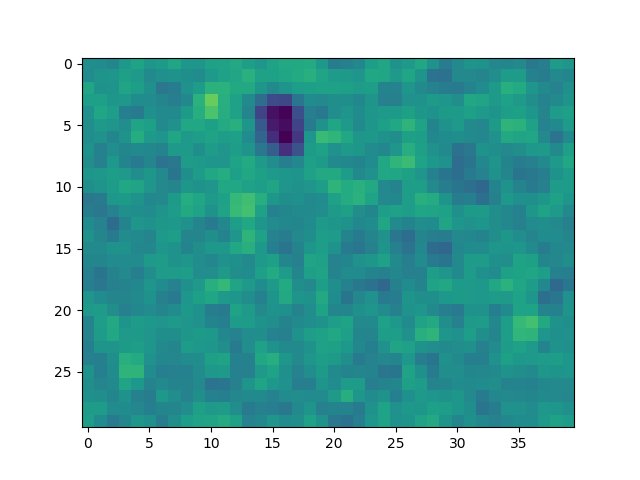

In [ ]:
cell_id = 0
plt.figure()
plt.imshow(result_sta[cell_id, -15], vmin=-1, vmax=1)

In [ ]:
#export
def cross_correlation(spike_counts, tail_len=50):
    """From `spike_counts` of shape (n_dpoints, n_cell), calculate the cross correlation
    of the cells over a window of `tail_len`*2 centered on the middle of the trace."""
    n_dpoints, n_cell = spike_counts.shape
    corr_arr = np.zeros((n_cell,n_cell,tail_len*2+1))
    spike_counts = (spike_counts / np.max(spike_counts, axis=0)) #Independant normalization of the cells
    spike_counts_edged = np.concatenate((np.zeros((tail_len,n_cell)), 
                    spike_counts, 
                    np.zeros((tail_len,n_cell)))) #Creating an array with 0 tails on both side to use the valid mode
                                                  # of numpy.correlate
    for i in range(n_cell):
        for j in range(i, n_cell):
            corr_arr[i,j] = np.correlate(spike_counts_edged[:,i],
                                         spike_counts[:,j], 
                                         mode="valid")
            corr_arr[j,i] = corr_arr[i,j]
    return corr_arr/n_dpoints

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"])
pipe += "checkerboard"
checker_corr = cross_correlation(pipe[0]["S_matrix"])

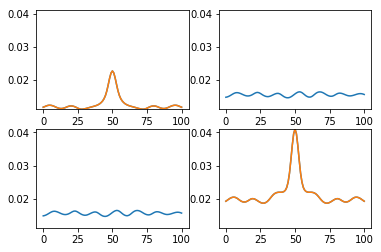

In [ ]:
n_cell = pipe[0]["S_matrix"].shape[1]
ymin, ymax = np.min(checker_corr), np.max(checker_corr)
for i in range(n_cell):
    for j in range(i, n_cell):
        plt.subplot(n_cell,n_cell,1+i*n_cell+j)
        plt.plot(checker_corr[i,j])
        plt.ylim([ymin,ymax])
        plt.subplot(n_cell,n_cell,1+j*n_cell+i)
        plt.plot(checker_corr[i,j])
        plt.ylim([ymin,ymax])

In [ ]:
#export
def stimulus_ensemble(stim_inten, Hw=30, x=0, y=0, w=None, h=None):
    stim_inten = stim_inten_norm(stim_inten)
    if w is None:
        w = stim_inten.shape[2]
    if h is None:
        h = stim_inten.shape[1]
    stim_ensmbl = np.zeros((len(stim_inten)-Hw, w*h*Hw))
    for i in range(Hw, len(stim_inten)):
        flat_stim         = np.ndarray.flatten(stim_inten[i-Hw:i,
                                                          y:y+h,
                                                          x:x+w])
        stim_ensmbl[i-Hw] = flat_stim
    return stim_ensmbl

def process_nonlinearity(stim_ensemble, spike_bins):
    """Stimulus must already have been converted to the stim_ensemble, so spike_bins must also
    not include the history window a the beggining."""
    assert len(stim_ensemble)==len(spike_bins)
    stim_ensmbl_mean  = np.mean(stim_ensemble,axis=0)#np.mean(spike_triggering_stimuli,axis=0)
    spike_ensmbl_mean = np.average(stim_ensemble, axis=0, weights=spike_bins)
    middle_vec = np.mean(np.stack((stim_ensmbl_mean, spike_ensmbl_mean)), axis=0)
    
    pca = PCA(n_components=2)
    fit = pca.fit(np.stack((stim_ensmbl_mean,
                            spike_ensmbl_mean,
                            middle_vec)))
    stim_ensemble_tranfo = fit.transform(stim_ensemble)
    
    if np.min(spike_bins)<1:#We have probabilities, not spike counts. Need to make it integers
        mask        = np.where(spike_bins > 0)[0]
        nonzero_min = np.min(spike_bins[mask])
        discretized = spike_bins/nonzero_min
        spike_bins  = ((10*discretized)/(np.max(discretized))).astype(int)
    spike_ensembl = []
    for n_spike, stim_transfo in zip(spike_bins, stim_ensemble_tranfo):
        spike_ensembl.extend([stim_transfo]*n_spike)
    
    xaxis      = np.linspace(np.min(stim_ensemble_tranfo),np.max(stim_ensemble_tranfo),101)
    hist_all   = np.histogram(stim_ensemble_tranfo, bins=xaxis)[0]
    hist_trigg = np.histogram(spike_ensembl, bins=xaxis)[0]
    
    nonlin = hist_trigg/hist_all
    
    #Nan handling by taking the mean around it
    idx_nans = np.where(np.isnan(nonlin))[0]
    for idx_nan in idx_nans:
        mean, n = 0,0
        if idx_nan == 0 and (idx_nan-1) not in idx_nans:
            mean += nonlin[idx_nan-1]
            n += 1
        if idx_nan != len(nonlin) and (idx_nan+1) not in idx_nans:
            mean += nonlin[idx_nan+1]
            n += 1
        nonlin[idx_nan] = mean/n
        
    return nonlin/np.max(nonlin)
        

C:\Users\tombo\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


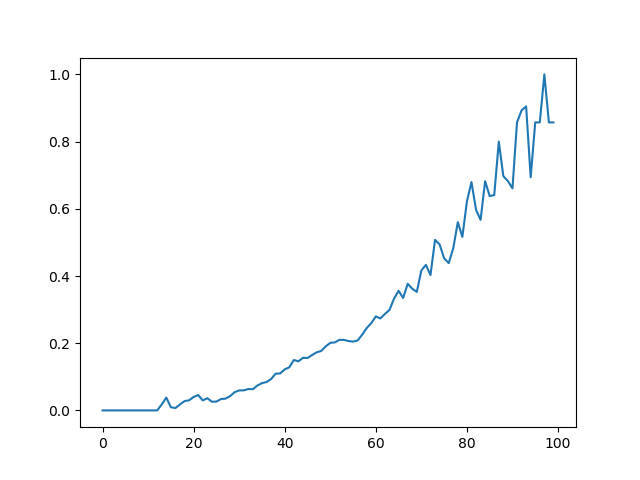

In [ ]:
stim_ensembl = stimulus_ensemble(stim_inten_corrected)
nonlin = process_nonlinearity(stim_ensembl, pipe[0]["spike_counts"][30:,0])
plt.figure()
plt.plot(nonlin)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted index.ipynb.
